# Covid19 Mortality rate stats

## library imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## load data

In [2]:
df__deaths = pd.read_csv("data/dst__deaths_per_age_and_year.csv")
df__population = pd.read_csv("data/dst__population_by_age_and_year.csv")

population_row__99_or_older = {
    df__population.columns[index]: value for index, value in enumerate(df__population[
        df__population["age"] > 98
    ].sum())
}
population_row__99_or_older["age"] = "99_or_older"
population_row__99_or_older__columns = population_row__99_or_older.keys()
population_row__99_or_older__values = [
    population_row__99_or_older[x_i] for x_i in population_row__99_or_older__columns]

df__population__99_or_older = pd.DataFrame(
    [population_row__99_or_older__values],
    columns=population_row__99_or_older__columns)

df__population_less_than_99 = df__population[df__population["age"] < 99].copy()
df__population_less_than_99["age"] = df__population_less_than_99["age"].astype(str)

df__population = pd.concat([
    df__population_less_than_99,
    df__population__99_or_older], axis=0)

available_years = df__deaths.columns[1:]
available_ages = df__deaths["age"]

observed_mortatility_rates = []
for year in available_years:
    for age in available_ages:
        death_value = df__deaths[(df__deaths["age"] == age)][year].iloc[0]
        population_value = df__population[(df__population["age"] == age)][year].iloc[0]
        ratio = death_value / (population_value + 1e-5)

        row = [year, age, ratio, death_value, population_value]
        observed_mortatility_rates.append(row)

df__mortality = pd.DataFrame(observed_mortatility_rates,
                             columns=["year", "age", "mortality",
                                      "deaths", "population"])

def age_grouper(x):
    if x == "99_or_older":
        return "5__greater_than_98"
    elif int(x) <= 30:
        return "1__less_than_30"
    elif int(x) <= 50:
        return "2__greater_than_30_less_than_50"
    elif int(x) <= 70:
        return "3__greater_than_50_less_than_70"
    elif int(x) <= 98:
        return "4__greater_than_570_less_than_98"
    else:
        return "5__greater_than_98"

df__mortality["age_group"] = df__mortality["age"].apply(age_grouper)
df__mortality = df__mortality\
    .groupby(["year", "age_group"])\
    .agg(deaths=("deaths", "sum"),
         population=("population", "sum"))\
    .reset_index()
df__mortality["mortality_rate"] = df__mortality["deaths"] / df__mortality["population"]

## visualizations

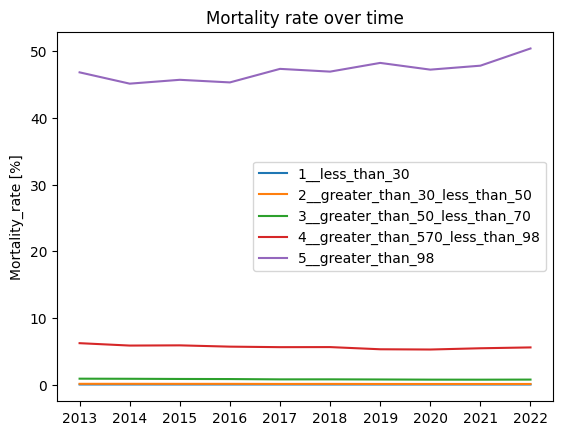

In [3]:
age_groups = sorted(set(df__mortality["age_group"]))

plt.figure()
plt.title("Mortality rate over time")
for age_group in age_groups:
    df__iter = df__mortality[df__mortality["age_group"] == age_group]

    plt.plot(df__iter["year"], df__iter["mortality_rate"] * 100,
             label=age_group)

plt.legend()
plt.ylabel("Mortality_rate [%]")
plt.show()

## Compute statistics

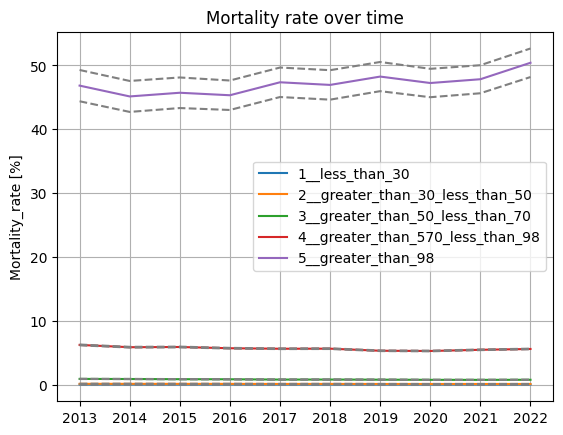

In [4]:
df__mortality["confidence_interval_scaler"] = \
    df__mortality["mortality_rate"] * (1 - df__mortality["mortality_rate"])\
    / df__mortality["population"]
df__mortality["confidence_interval_scaler"] = np.sqrt(
    df__mortality["confidence_interval_scaler"])
df__mortality["mortality_rate__lb"] = df__mortality["mortality_rate"] - 1.97 * \
    df__mortality["confidence_interval_scaler"]
df__mortality["mortality_rate__ub"] = df__mortality["mortality_rate"] + 1.97 * \
    df__mortality["confidence_interval_scaler"]

age_groups = sorted(set(df__mortality["age_group"]))

plt.figure()
plt.title("Mortality rate over time")
for age_group in age_groups:
    df__iter = df__mortality[df__mortality["age_group"] == age_group]

    plt.plot(df__iter["year"], df__iter["mortality_rate"] * 100,
             label=age_group)
    plt.plot(df__iter["year"], df__iter["mortality_rate__lb"] * 100,
             ls="--", color="grey")
    plt.plot(df__iter["year"], df__iter["mortality_rate__ub"] * 100,
             ls="--", color="grey")


plt.legend()
plt.ylabel("Mortality_rate [%]")
plt.grid()
plt.show()